In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from curl_cffi import requests
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import talib as ta
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pickle
from hmmlearn.hmm import GaussianHMM


In [2]:
session = requests.Session(impersonate="chrome")

In [3]:
# ticker = "^NSEI"
# df_obj = yf.Ticker(ticker, session=session)
# data = df_obj.history(period="max", interval="1d")

In [14]:
# with open('../../data/nifty_data.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('../../data/nifty_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
# (Timestamp('2015-09-16 00:00:00'), Timestamp('2025-09-15 00:00:00'))


In [16]:
df= data.copy()

In [35]:
df.index

DatetimeIndex(['2007-09-17 00:00:00+05:30', '2007-09-18 00:00:00+05:30',
               '2007-09-19 00:00:00+05:30', '2007-09-20 00:00:00+05:30',
               '2007-09-21 00:00:00+05:30', '2007-09-24 00:00:00+05:30',
               '2007-09-25 00:00:00+05:30', '2007-09-26 00:00:00+05:30',
               '2007-09-27 00:00:00+05:30', '2007-09-28 00:00:00+05:30',
               ...
               '2025-09-08 00:00:00+05:30', '2025-09-09 00:00:00+05:30',
               '2025-09-10 00:00:00+05:30', '2025-09-11 00:00:00+05:30',
               '2025-09-12 00:00:00+05:30', '2025-09-15 00:00:00+05:30',
               '2025-09-16 00:00:00+05:30', '2025-09-17 00:00:00+05:30',
               '2025-09-18 00:00:00+05:30', '2025-09-19 00:00:00+05:30'],
              dtype='datetime64[ns, Asia/Kolkata]', name='Date', length=4418, freq=None)

In [7]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-15 00:00:00+05:30,25118.900391,25138.449219,25048.750000,25069.199219,185400,0.0,0.0
2025-09-16 00:00:00+05:30,25073.599609,25261.400391,25070.449219,25239.099609,240100,0.0,0.0
2025-09-17 00:00:00+05:30,25276.599609,25346.500000,25275.349609,25330.250000,268900,0.0,0.0


In [40]:
# df['return_1d'] = df['Close'].pct_change()
# df['return_5d'] = df['Close'].pct_change(5)
# df['vol_10d'] = df['return_1d'].rolling(10).std()
# df['vol_20d'] = df['return_1d'].rolling(20).std()
# df['momentum_10d'] = df['Close'].pct_change(10)
# df['drawdown'] = df['Close'] / df['Close'].cummax() - 1

# # 3. Prepare feature matrix
# features = df[['return_1d', 'return_5d', 'vol_10d', 'vol_20d', 'momentum_10d', 'drawdown']].dropna()

In [8]:
df['return_1d'] = df['Close'].pct_change()
df['return_5d'] = df['Close'].pct_change(5)
df['momentum_10d'] = ta.MOM(df['Close'], timeperiod=10)
df['ma_ratio'] = df['Close'] / ta.SMA(df['Close'], timeperiod=50)

# Risk Features
df['vol_10d'] = df['return_1d'].rolling(10).std()
df['vol_20d'] = df['return_1d'].rolling(20).std()
df['vol_ratio'] = df['vol_10d'] / df['vol_20d']
df['atr_14'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14) / df['Close']

# Stress Features
df['drawdown'] = df['Close'] / df['Close'].cummax() - 1

# Exhaustion Features
df['rsi_14'] = ta.RSI(df['Close'], timeperiod=14)

# Participation Features (if Volume available)
if 'Volume' in df.columns:
    df['vol_zscore'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()
    df['obv'] = ta.OBV(df['Close'], df['Volume'])
else:
    df['vol_zscore'] = np.nan
    df['obv'] = np.nan

# Collect feature set
features_orig = df[['return_1d', 'return_5d', 'momentum_10d', 'ma_ratio',
               'vol_10d', 'vol_20d', 'vol_ratio', 'atr_14',
               'drawdown', 'rsi_14', 'vol_zscore', 'obv']].dropna()

In [102]:
features_orig

,return_1d,return_5d,momentum_10d,ma_ratio,vol_10d,vol_20d,vol_ratio,atr_14,drawdown,rsi_14,vol_zscore,obv
Date,,,,,,,,,,,,
2015-03-17 00:00:00+05:30,0.010442,0.001291,-233.450195,1.006244,0.009786,0.009467,1.033711,0.013662,-0.030340,48.796191,-0.052423,1310700.0
2015-03-18 00:00:00+05:30,-0.004287,-0.001615,-310.349609,1.001259,0.009476,0.009503,0.997143,0.013426,-0.034498,46.801615,-0.694865,1154300.0
2015-03-19 00:00:00+05:30,-0.005900,-0.016106,-288.000000,0.994764,0.009377,0.009403,0.997229,0.013976,-0.040194,44.139043,-0.517284,990800.0
2015-03-20 00:00:00+05:30,-0.007383,-0.008887,-366.849609,0.986411,0.009286,0.009441,0.983543,0.013755,-0.047281,41.013415,-0.126733,816200.0
2015-03-23 00:00:00+05:30,-0.002333,-0.009527,-205.849609,0.983094,0.007361,0.009365,0.786024,0.013369,-0.049504,40.055103,-0.789981,665500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15 00:00:00+05:30,-0.001784,0.011950,444.148438,1.006913,0.002587,0.005349,0.483615,0.007133,-0.043746,59.007310,-0.793888,67175100.0
2025-09-16 00:00:00+05:30,0.006777,0.014898,659.500000,1.013918,0.002675,0.005105,0.523952,0.007123,-0.037265,63.840711,-0.296786,67415200.0
2025-09-17 00:00:00+05:30,0.003611,0.014301,615.199219,1.017687,0.002512,0.005087,0.493816,0.006893,-0.033788,66.146894,-0.064681,67684100.0


In [30]:
features = features_orig.copy()

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [42]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
features['kmeans_cluster'] = kmeans.fit_predict(X)

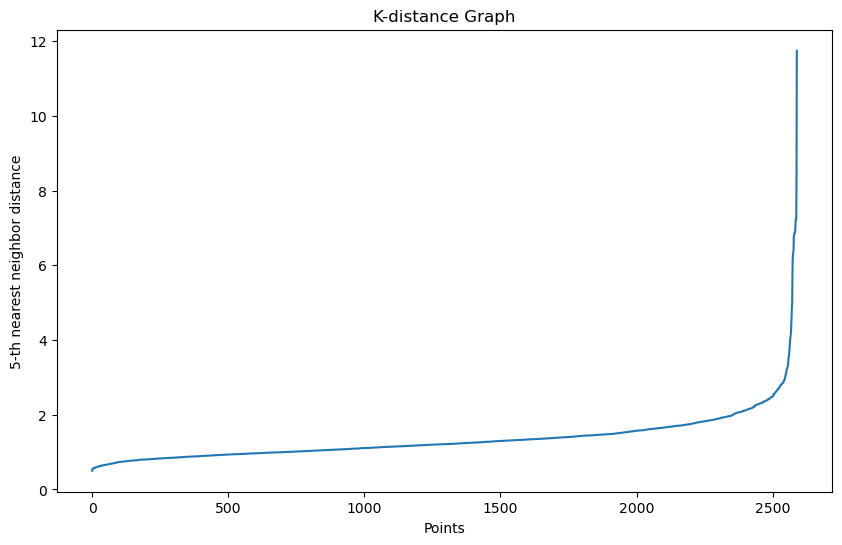

In [43]:
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(X, k=5)



In [56]:
epsilon = 5 # Chosen based on k-distance graph
min_samples = 2 * X.shape[1]  # 2 times the number of features
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

features['dbscan_cluster'] = clusters

In [71]:
hmm = GaussianHMM(n_components=5, covariance_type="full", n_iter=2000).fit(X)
features['hmm_cluster'] = hmm.predict(X)

In [31]:
df_merged = df.join(features[['kmeans_cluster', 'dbscan_cluster',"hmm_cluster" ]], how='right')

# # 6. Inspect cluster centers (for interpretation)
# centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns[:-1])
# print("Cluster centroids (in standardized scale):")
# print(centroids)

NameError: name 'features' is not defined

In [30]:
df_merged

NameError: name 'df_merged' is not defined

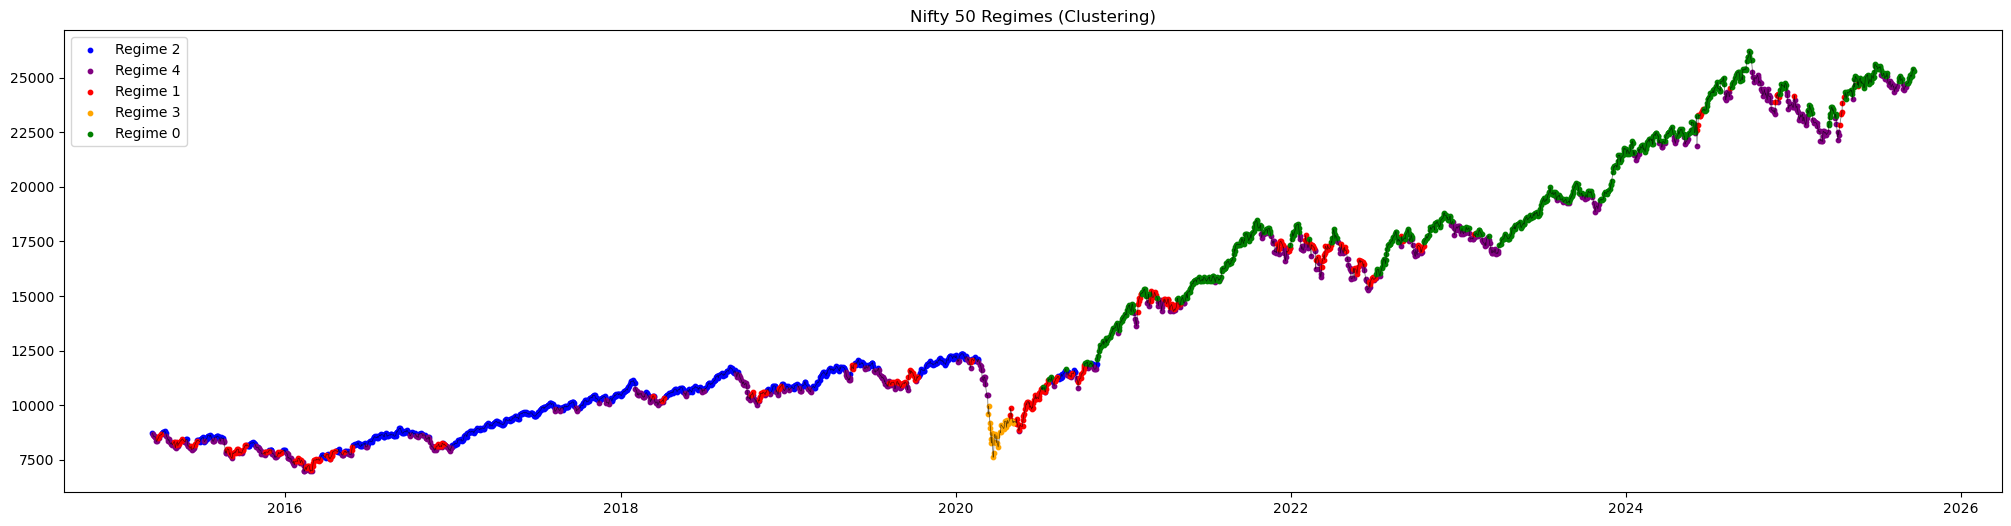

In [48]:
plt.figure(figsize=(25,6))
colors = {0:"green", 1:"red", 2:"blue", 3:"orange", 4:"purple", 5:"brown", 6:"pink", 7:"gray", 8:"cyan", 9:"magenta"}
for c in df_merged['kmeans_cluster'].dropna().unique():
    mask = df_merged['kmeans_cluster'] == c
    plt.scatter(df_merged.index[mask], df_merged['Close'][mask], label=f"Regime {c}", s=10, c=colors[c])
plt.plot(df_merged.index, df_merged['Close'], color='black', linewidth=0.5, alpha=0.6)
plt.title("Nifty 50 Regimes (Clustering)")
plt.legend()
plt.show()

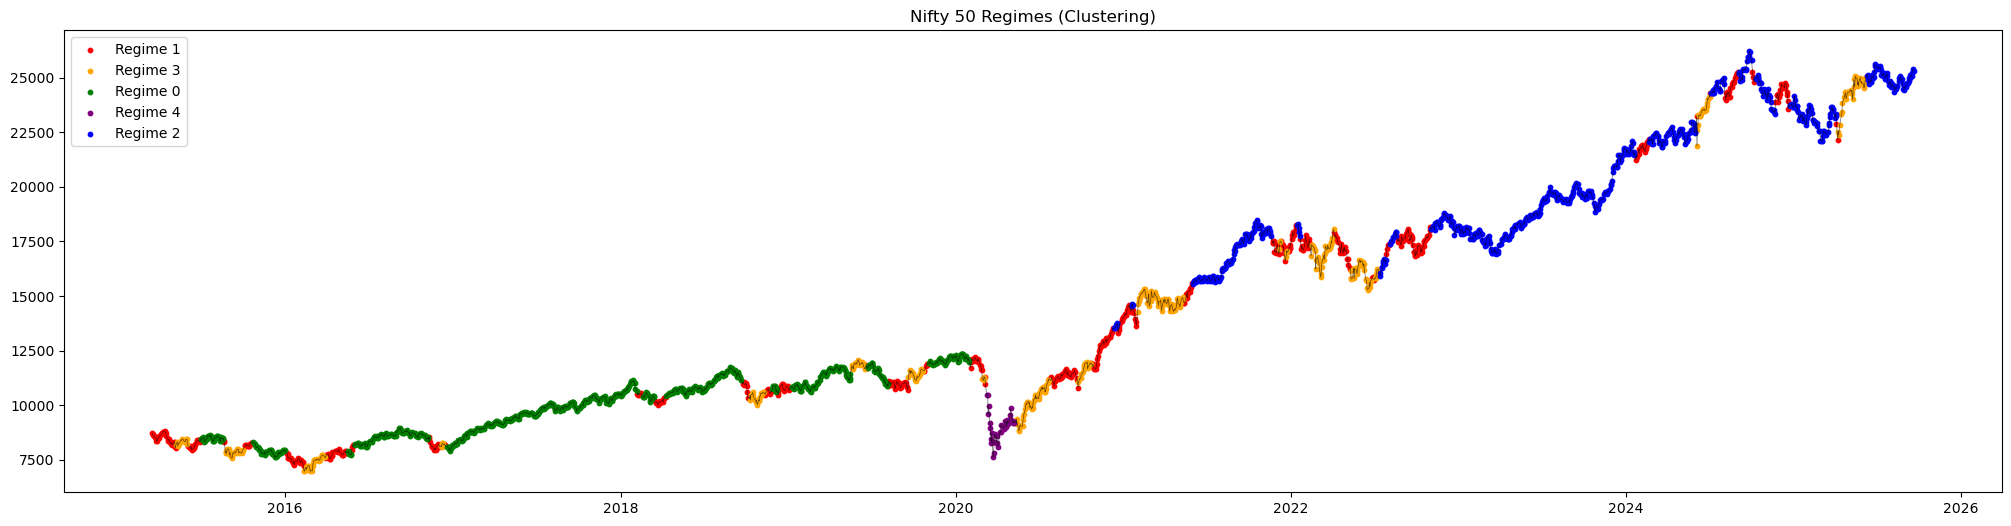

In [74]:
plt.figure(figsize=(25,6))
colors = {0:"green", 1:"red", 2:"blue", 3:"orange", 4:"purple", 5:"brown", 6:"pink", 7:"gray", 8:"cyan", 9:"magenta"}
for c in df_merged['hmm_cluster'].dropna().unique():
    mask = df_merged['hmm_cluster'] == c
    plt.scatter(df_merged.index[mask], df_merged['Close'][mask], label=f"Regime {c}", s=10, c=colors[c])
plt.plot(df_merged.index, df_merged['Close'], color='black', linewidth=0.5, alpha=0.6)
plt.title("Nifty 50 Regimes (Clustering)")
plt.legend()
plt.show()

In [59]:
features['dbscan_cluster'].value_counts()

dbscan_cluster
 0    2565
-1      25
Name: count, dtype: int64

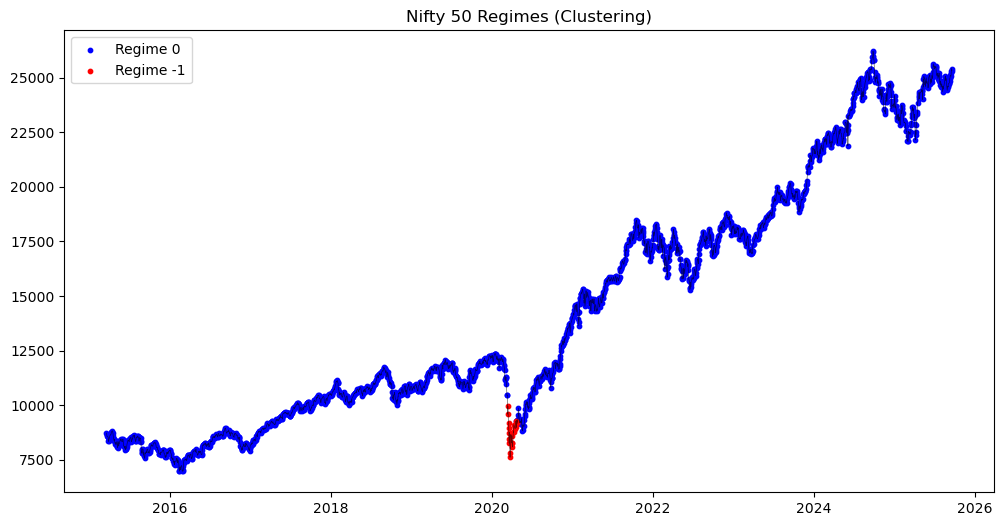

In [60]:
plt.figure(figsize=(12,6))
colors = {1:"green", -1:"red", 0:"blue"}
for c in df_merged['dbscan_cluster'].dropna().unique():
    mask = df_merged['dbscan_cluster'] == c
    plt.scatter(df_merged.index[mask], df_merged['Close'][mask], label=f"Regime {c}", s=10, c=colors[c])
plt.plot(df_merged.index, df_merged['Close'], color='black', linewidth=0.5, alpha=0.6)
plt.title("Nifty 50 Regimes (Clustering)")
plt.legend()
plt.show()

In [89]:
final = df_merged[[ "kmeans_cluster","hmm_cluster"]]

In [90]:
final = final.reset_index()

In [93]:
final["Date"] = pd.to_datetime(final['Date'])
# remove timezone info
final['Date'] = final['Date'].dt.tz_localize(None)

In [94]:
final

,Date,kmeans_cluster,hmm_cluster
0,2015-03-17,2,1
1,2015-03-18,4,1
2,2015-03-19,4,1
3,2015-03-20,4,1
4,2015-03-23,4,1
...,...,...,...
2585,2025-09-15,0,2
2586,2025-09-16,0,2
2587,2025-09-17,0,2
2588,2025-09-18,0,2


In [84]:
# with open("../../data/nifty_regimes.pkl", 'wb') as f:
#     pickle.dump(final, f)

with open("../../data/nifty_regimes.pkl", 'rb') as f:
    final = pickle.load(f)

In [85]:
final=final.set_index('Date')

In [86]:
final

,kmeans_cluster,hmm_cluster
Date,,
2015-03-17,2,1
2015-03-18,4,1
2015-03-19,4,1
2015-03-20,4,1
2015-03-23,4,1
...,...,...
2025-09-15,0,2
2025-09-16,0,2
2025-09-17,0,2


In [87]:
full_idx = pd.date_range(final.index.min(), final.index.max(), freq="D")
final = final.reindex(full_idx)

In [65]:
full_idx

DatetimeIndex(['2015-03-17', '2015-03-18', '2015-03-19', '2015-03-20',
               '2015-03-21', '2015-03-22', '2015-03-23', '2015-03-24',
               '2015-03-25', '2015-03-26',
               ...
               '2025-09-10', '2025-09-11', '2025-09-12', '2025-09-13',
               '2025-09-14', '2025-09-15', '2025-09-16', '2025-09-17',
               '2025-09-18', '2025-09-19'],
              dtype='datetime64[ns]', length=3840, freq='D')

In [88]:
final=final.bfill()

In [90]:
final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3840 entries, 2015-03-17 to 2025-09-19
Freq: D
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kmeans_cluster  3840 non-null   float64
 1   hmm_cluster     3840 non-null   float64
dtypes: float64(2)
memory usage: 90.0 KB


In [92]:
final.loc['2016-08-12 00:00:00']

kmeans_cluster    2.0
hmm_cluster       0.0
Name: 2016-08-12 00:00:00, dtype: float64

In [12]:
# with open("../../data/nifty_regimes_m.pkl", 'wb') as f:
#     pickle.dump(final, f)

with open("../../data/nifty_regimes_m.pkl", 'rb') as f:
    final = pickle.load(f)

In [13]:
final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3840 entries, 2015-03-17 to 2025-09-19
Freq: D
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kmeans_cluster  3840 non-null   float64
 1   hmm_cluster     3840 non-null   float64
dtypes: float64(2)
memory usage: 90.0 KB


In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'return_1d', 'return_5d', 'momentum_10d', 'ma_ratio', 'vol_10d',
       'vol_20d', 'vol_ratio', 'atr_14', 'drawdown', 'rsi_14', 'vol_zscore',
       'obv'],
      dtype='object')

In [18]:
df=df.drop(columns=['Dividends', 'Stock Splits', 'Volume'])

In [19]:
df

,Open,High,Low,Close
Date,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805
...,...,...,...,...
2025-09-15 00:00:00+05:30,25118.900391,25138.449219,25048.750000,25069.199219
2025-09-16 00:00:00+05:30,25073.599609,25261.400391,25070.449219,25239.099609
2025-09-17 00:00:00+05:30,25276.599609,25346.500000,25275.349609,25330.250000


In [ ]:
df['return_5d'] = df['Close'].pct_change(5)
df["return_10d"] = df['Close'].pct_change(10)
df['return_20d'] = df['Close'].pct_change(20)
df['momentum_5d'] = ta.MOM(df['Close'], timeperiod=5)
df['momentum_10d'] = ta.MOM(df['Close'], timeperiod=10)
df['momentum_20d'] = ta.MOM(df['Close'], timeperiod=20)

In [23]:
df

,Open,High,Low,Close,return_5d,roc_5d,momentum_5d,momentum_10d
Date,,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,NaN,NaN,NaN,NaN
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,NaN,NaN,NaN,NaN
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,NaN,NaN,NaN,NaN
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,NaN,NaN,NaN,NaN
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-09-15 00:00:00+05:30,25118.900391,25138.449219,25048.750000,25069.199219,0.011950,1.195039,296.048828,444.148438
2025-09-16 00:00:00+05:30,25073.599609,25261.400391,25070.449219,25239.099609,0.014898,1.489831,370.500000,659.500000
2025-09-17 00:00:00+05:30,25276.599609,25346.500000,25275.349609,25330.250000,0.014301,1.430140,357.150391,615.199219
